In [1]:
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np
# Library for Gaussian process
import GPy
##Library for visualization
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib;matplotlib.rcParams['figure.figsize'] = (8,6)
import pylab 

/Users/liy0h/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
n = 30 
N = int(n**2) ## sample size
M = 1 ## Number of replicate
coord1 = np.linspace(0,1,n)
coord2 = np.linspace(0,1,n)
P = 1
X = np.array([np.ones(N)]).T
s1,s2 = np.meshgrid(coord1,coord2)
s = np.vstack((s1.flatten(),s2.flatten())).T
np.random.seed(2)
#y=np.sin(10*np.pi*s)/(2*s) + (s - 1)**4 
y = np.sin(30*((s[:,0]+s[:,1])/2-0.9)**4)*np.cos(2*((s[:,0]+s[:,1])/2-0.9))+((s[:,0]+s[:,1])/2-0.9)/2

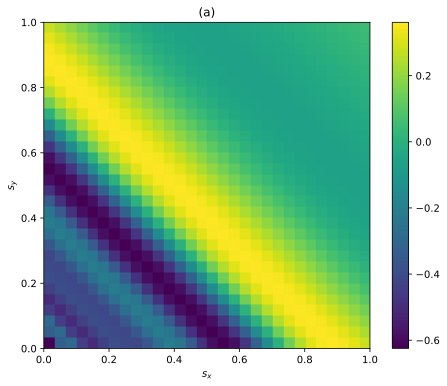

In [18]:
##Visualization
y_mat = y.reshape(n,n)
fig, ax = plt.subplots()
im = ax.imshow(y_mat , extent=[0, 1, 0, 1], origin="lower",
               vmax=y_mat .max(), vmin=y_mat .min())
plt.xlabel('$s_x$')
plt.ylabel('$s_y$')
plt.title('(a)')
plt.colorbar(im)
#plt.show()
plt.savefig("nonstat_fun_2d.pdf")

In [4]:
num_basis = [10**2,19**2,37**2]
knots_1d = [np.linspace(0,1,np.sqrt(i)) for i in num_basis]
##Wendland kernel
K = 0
phi = np.zeros((N, sum(num_basis)))
for res in range(len(num_basis)):
    theta = 1/np.sqrt(num_basis[res])*2.5
    knots_s1, knots_s2 = np.meshgrid(knots_1d[res],knots_1d[res])
    knots = np.column_stack((knots_s1.flatten(),knots_s2.flatten()))
    for i in range(num_basis[res]):
        d = np.linalg.norm(s-knots[i,:],axis=1)/theta
        for j in range(len(d)):
            if d[j] >= 0 and d[j] <= 1:
                phi[j,i + K] = (1-d[j])**6 * (35 * d[j]**2 + 18 * d[j] + 3)/3
            else:
                phi[j,i + K] = 0
    K = K + num_basis[res]

In [5]:
def deep_model(model, X_train, y_train, X_valid, y_valid, data_type):
    '''
    Function to train a multi-class model. The number of epochs and 
    batch_size are set by the constants at the top of the
    notebook. 
    
    Parameters:
        model : model with the chosen architecture
        X_train : training features
        y_train : training target
        X_valid : validation features
        Y_valid : validation target
    Output:
        model training history
    '''
    if data_type == 'continuous':
        model.compile(optimizer='adam'
                      , loss='mse'
                      , metrics=['mse','mae'])
    if data_type == 'discrete':
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    history = model.fit(X_train
                       , y_train
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=0)
    return history

def test_model(model, X_train, y_train, X_test, y_test, epoch_stop):
    '''
    Function to test the model on new data after training it
    on the full training data with the optimal number of epochs.
    
    Parameters:
        model : trained model
        X_train : training features
        y_train : training target
        X_test : test features
        y_test : test target
        epochs : optimal number of epochs
    Output:
        test accuracy and test loss
    '''
    model.fit(X_train
              , y_train
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=0)
    results = model.evaluate(X_test, y_test, verbose=0)
    return results
    
def optimal_epoch(model_hist):
    '''
    Function to return the epoch number where the validation loss is
    at its minimum
    
    Parameters:
        model_hist : training history of model
    Output:
        epoch number with minimum validation loss
    '''
    min_epoch = np.argmin(model_hist.history['val_loss']) + 1
    return min_epoch

In [6]:
# DeepKriging model for continuous data
model = Sequential()
model.add(Dense(100, input_dim = K,  kernel_initializer='he_uniform', activation='relu'))
#model.add(Dropout(rate=0.5))
#model.add(BatchNormalization())
model.add(Dense(100, activation='relu'))
#model.add(Dropout(rate=0.5))
model.add(Dense(100, activation='relu'))
#model.add(BatchNormalization())
model.add(Dense(1, activation='linear'))

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
# Baseline DNN only with covariates and coordinates
# Neural network
model_base = Sequential()
model_base.add(Dense(100, input_dim=2,  kernel_initializer='he_uniform', activation='relu'))
#model_base.add(Dropout(rate=0.5))
#model_base.add(BatchNormalization())
model_base.add(Dense(100, activation='relu'))
#model_base.add(Dropout(rate=0.5))
model_base.add(Dense(100, activation='relu'))
#model_base.add(BatchNormalization())
model_base.add(Dense(1, activation='linear'))

In [8]:
from sklearn.model_selection import KFold
NB_START_EPOCHS = 200  # Number of epochs we usually start to train with
BATCH_SIZE = 64  # Size of the batches used in the mini-batch gradient descent

In [9]:
def mse(y_pred,y_true):
    mse = np.mean((y_pred-y_true)**2)
    return mse

def mae(y_pred,y_true):
    mae = np.mean(np.absolute(y_pred-y_true))
    return mae

In [10]:
num_folds = 10
kfold = KFold(n_splits=num_folds, shuffle=True, random_state = 123)
fold_no = 1
inputs = phi
inputs_base = s
targets = y
mse_per_fold = []
mse_per_fold_base = []
mse_per_fold_gp = []
mae_per_fold = []
mae_per_fold_base = []
mae_per_fold_gp = []
for train_idx, test_idx in kfold.split(inputs, targets):
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    history = deep_model(model, inputs[train_idx,:], targets[train_idx], inputs[test_idx,:], targets[test_idx],'continuous')
    history_base = deep_model(model_base, inputs_base[train_idx], targets[train_idx]
                              , inputs_base[test_idx], targets[test_idx],'continuous')
    model_optim = 200#optimal_epoch(history)
    model_optim_base = 200#optimal_epoch(history_base)
    result = test_model(model, inputs[train_idx,:], targets[train_idx], inputs[test_idx,:]
                        , targets[test_idx], model_optim)
    result_base = test_model(model_base, inputs_base[train_idx,:], targets[train_idx], inputs_base[test_idx,:]
                             , targets[test_idx], model_optim_base)
    scores = result
    scores_base = result_base
    print(f'The performance of DeepKriging: MSE = {scores[1]}, MAE = {scores[2]}')
    print(f'The performance of classical DNN: MSE = {scores_base[1]}, MAE = {scores_base[2]}')
    ker = GPy.kern.Exponential(2,1,1)
    # create simple GP model
    m = GPy.models.GPRegression(s[train_idx],targets[train_idx,None],ker)
    # optimize and plot
    m.optimize(messages=True)
    z_gp_test,gp_var=m.predict(s[test_idx])
    scores_gp = [mse(z_gp_test[:,0],targets[test_idx]),mae(z_gp_test[:,0],targets[test_idx])]
    print(f'The performance of Kriging: MSE = {scores_gp[0]}, MAE = {scores_gp[1]}')
    fold_no = fold_no + 1
    mse_per_fold.append(scores[1])
    mse_per_fold_base.append(scores_base[1])
    mse_per_fold_gp.append(scores_gp[0])
    mae_per_fold.append(scores[2])
    mae_per_fold_base.append(scores_base[2])
    mae_per_fold_gp.append(scores_gp[1])  

------------------------------------------------------------------------
Training for fold 1 ...
Instructions for updating:
Use tf.cast instead.
The performance of DeepKriging: MSE = 0.00024370133323827758, MAE = 0.01126275406115585
The performance of classical DNN: MSE = 0.00017012186678281674, MAE = 0.007260160820765628


Widget Javascript not detected.  It may not be installed or enabled properly.


The performance of Kriging: MSE = 0.00021127288839028932, MAE = 0.006063242034003102
------------------------------------------------------------------------
Training for fold 2 ...
The performance of DeepKriging: MSE = 6.028669441649173e-05, MAE = 0.005179198443268736
The performance of classical DNN: MSE = 9.93287214643917e-05, MAE = 0.007021324802190065


Widget Javascript not detected.  It may not be installed or enabled properly.


The performance of Kriging: MSE = 0.00013813051009705992, MAE = 0.005711849127459698
------------------------------------------------------------------------
Training for fold 3 ...
The performance of DeepKriging: MSE = 2.465838778233673e-05, MAE = 0.003705127226809661
The performance of classical DNN: MSE = 2.884257109043473e-05, MAE = 0.004397936993175083


Widget Javascript not detected.  It may not be installed or enabled properly.


The performance of Kriging: MSE = 7.141829170726925e-05, MAE = 0.004273094215235342
------------------------------------------------------------------------
Training for fold 4 ...
The performance of DeepKriging: MSE = 1.605478533343153e-05, MAE = 0.002474846701241202
The performance of classical DNN: MSE = 1.414281642711204e-05, MAE = 0.0028154051914397213


Widget Javascript not detected.  It may not be installed or enabled properly.


The performance of Kriging: MSE = 0.00013548015768987507, MAE = 0.00646886061354759
------------------------------------------------------------------------
Training for fold 5 ...
The performance of DeepKriging: MSE = 2.98679759149915e-05, MAE = 0.0026740156165841553
The performance of classical DNN: MSE = 0.0004634661184455682, MAE = 0.011931886937883164


Widget Javascript not detected.  It may not be installed or enabled properly.


The performance of Kriging: MSE = 0.0013051279801659754, MAE = 0.00838302971118516
------------------------------------------------------------------------
Training for fold 6 ...
The performance of DeepKriging: MSE = 1.7673689676990358e-05, MAE = 0.0020442974081055984
The performance of classical DNN: MSE = 5.245982568643134e-05, MAE = 0.005346654076129198


Widget Javascript not detected.  It may not be installed or enabled properly.


The performance of Kriging: MSE = 0.00011963701952178438, MAE = 0.005588676026958684
------------------------------------------------------------------------
Training for fold 7 ...
The performance of DeepKriging: MSE = 2.737395629487259e-05, MAE = 0.004451249767508772
The performance of classical DNN: MSE = 6.408077432651125e-05, MAE = 0.004106582985776994


Widget Javascript not detected.  It may not be installed or enabled properly.


The performance of Kriging: MSE = 0.0002995715092747102, MAE = 0.007660876952654153
------------------------------------------------------------------------
Training for fold 8 ...
The performance of DeepKriging: MSE = 4.9124430006486365e-06, MAE = 0.0015688136918470263
The performance of classical DNN: MSE = 2.4353158854258556e-05, MAE = 0.004116599194498526


Widget Javascript not detected.  It may not be installed or enabled properly.


The performance of Kriging: MSE = 4.849336800402201e-05, MAE = 0.0035522099863304064
------------------------------------------------------------------------
Training for fold 9 ...
The performance of DeepKriging: MSE = 3.226840155750526e-06, MAE = 0.0014180148175607125
The performance of classical DNN: MSE = 1.4535556783812353e-05, MAE = 0.002579238260578778


Widget Javascript not detected.  It may not be installed or enabled properly.


The performance of Kriging: MSE = 0.00023254566100611745, MAE = 0.00607138543345944
------------------------------------------------------------------------
Training for fold 10 ...
The performance of DeepKriging: MSE = 5.521529894597027e-06, MAE = 0.0017823740762347975
The performance of classical DNN: MSE = 6.365777749629665e-06, MAE = 0.0018376582560853825


Widget Javascript not detected.  It may not be installed or enabled properly.


The performance of Kriging: MSE = 0.00033819952170152705, MAE = 0.008764171982426015


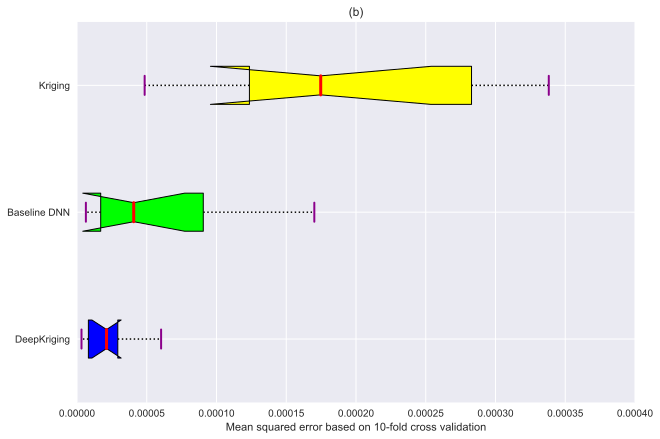

In [35]:
import matplotlib as mpl
mpl.style.use("seaborn")
data= [mse_per_fold,mse_per_fold_base,mse_per_fold_gp]
fig = plt.figure(figsize =(10, 7)) 
ax = fig.add_subplot(111) 
  
# Creating axes instance 
bp = ax.boxplot(data, patch_artist = True, 
                notch ='True', vert = 0) 
  
colors = ['#0000FF', '#00FF00',  
          '#FFFF00'] 
  
for patch, color in zip(bp['boxes'], colors): 
    patch.set_facecolor(color) 
  
# changing color and linewidth of 
# whiskers 
for whisker in bp['whiskers']: 
    whisker.set(color ='black', 
                linewidth = 1.5, 
                linestyle =":") 
  
# changing color and linewidth of 
# caps 
for cap in bp['caps']: 
    cap.set(color ='#8B008B', 
            linewidth = 2) 
  
# changing color and linewidth of 
# medians 
for median in bp['medians']: 
    median.set(color ='red', 
               linewidth = 3) 
  
# changing style of fliers 
for flier in bp['fliers']: 
    flier.set(marker ='D', 
              color ='#e7298a', 
              alpha = 0.5) 
      
# x-axis labels 
ax.set_yticklabels(['DeepKriging', 'Baseline DNN',  
                    'Kriging']) 
  
# Adding title  
plt.title("(b)") 
plt.xlabel('Mean squared error based on 10-fold cross validation')
plt.xlim((0,0.0004)) 
# Removing top axes and right axes 
# ticks 
ax.get_xaxis().tick_bottom() 
ax.get_yaxis().tick_left() 
      
# show plot 
#plt.show(bp) 
plt.savefig("boxplot.pdf")

In [15]:
print(np.mean(mse_per_fold))
print(np.std(mse_per_fold))
print(np.mean(mse_per_fold_base))
print(np.std(mse_per_fold_base))
print(np.mean(mse_per_fold_gp))
print(np.std(mse_per_fold_gp))
print(np.mean(mae_per_fold))
print(np.std(mae_per_fold))
print(np.mean(mae_per_fold_base))
print(np.std(mae_per_fold_base))
print(np.mean(mae_per_fold_gp))
print(np.std(mae_per_fold_gp))

4.332776357083882e-05
6.865601741049072e-05
9.376971876109668e-05
0.00013206667249671984
0.000289987690755863
0.0003499237440787517
0.0036560691810316515
0.002804462098636537
0.005141344751852254
0.002823819063991054
0.0062537396083259585
0.0015776303528670316


In [12]:
dk=[0.111, 0.075,0.048, 0.036]
gp=[0.165,0.137,0.061, 0.038]